In [3]:

import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib
# matplotlib.use('Agg')
%matplotlib inline

import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np

import utility as util

global logger

#util.setup_log()
#util.setup_path()
#logger = util.logger

use_cuda = torch.cuda.is_available()
#logger.info("Is CUDA available? %s.", use_cuda)


Shape of data: (40560, 82).
Missing in data: 0.
Training size: 28392.
Iterations per epoch: 221.812 ~ 222.


/Users/aleksey/anaconda3/envs/time-series/lib/python3.6/site-packages/ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/aleksey/anaconda3/envs/time-series/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/aleksey/anaconda3/envs/time-series/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/aleksey/anaconda3/envs/time-series/lib/python3.6/site-packages/ipykernel_launcher.py:216: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0, loss: 2312.991.


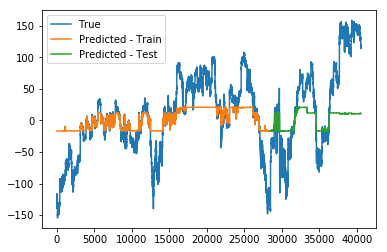

Epoch 2, loss: 776.499.


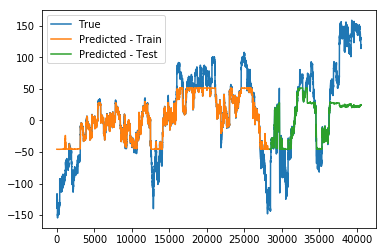

Epoch 4, loss: 298.630.


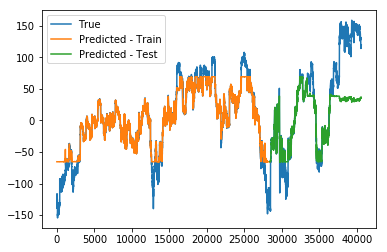

In [ ]:

class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)

    def forward(self, input_data):
        # input_data: batch_size * T - 1 * input_size
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
        # hidden, cell: initial states with dimention hidden_size
        hidden = self.init_hidden(input_data) # 1 * batch_size * hidden_size
        cell = self.init_hidden(input_data)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)
            # Eqn. 9: Get attention weights
            x = self.attn_linear(x.view(-1, self.hidden_size * 2 + self.T - 1)) # (batch_size * input_size) * 1
            attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size * input_size
            # Fix the warning about non-contiguous memory
            # see https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension

class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

   
        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

        self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size * T - 1 * encoder_hidden_size
        # y_history: batch_size * (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        # self.logger.info("hidden %s context %s y_pred: %s", hidden[0][0][:10], context[0][:10], y_pred[:10])
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())


# In[ ]:

# Train the model
class da_rnn:
    def __init__(self, file_data,  encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = False):
        self.T = T
        dat = pd.read_csv(file_data, nrows = 100 if debug else None)
        
        print("Shape of data: {}.\nMissing in data: {}.".format(dat.shape, dat.isnull().sum().sum()))

        self.X = dat.loc[:, [x for x in dat.columns.tolist() if x != 'NDX']].as_matrix()
        self.y = np.array(dat.NDX)
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T,
                              ) #.cuda()
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T) #.cuda()

        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        # self.learning_rate = learning_rate

        self.train_size = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_size]) # Question: why Adam requires data to be normalized?
        print("Training size: {}.".format(self.train_size))

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        print("Iterations per epoch: {:3.3f} ~ {}.".format(self.train_size * 1. / self.batch_size, iter_per_epoch))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in range(n_epochs):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                
                idx = int(i * iter_per_epoch + j / self.batch_size)                
                self.iter_losses[idx] = loss
                #if (j / self.batch_size) % 50 == 0:
                #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / self.batch_size, loss)
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                if learning_rate > self.learning_rate:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    learning_rate *= .9
                '''


            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 2 == 0:
                print("Epoch {:d}, loss: {:3.3f}.".format(i, self.epoch_losses[i]))

            if i % 2 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor))) #.cuda() 
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor))) #.cuda()

        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor)) #.cuda()
        loss = self.loss_func(y_pred.squeeze(), y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # if loss.data[0] < 10:
        #     self.logger.info("MSE: %s, loss: %s.", loss.data, (y_pred[:, 0] - y_true).pow(2).mean())

        return loss.data[0]

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]

            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor)) #.cuda()
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor))) #.cuda()
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size
        return y_pred




model = da_rnn(file_data = './data/nasdaq100_padding.csv', parallel = False, learning_rate = .001)

model.train(n_epochs = 500)

y_pred = model.predict()

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()